# Image Processing SoSe 2024 - Assignment - 03

### Deadline is 16.05.2024 at 12:00 p.m.

#### Students: Minh Tuan Nguyen, Vinzent Hannes Jörß

Please solve the assignments together with a partner.

Make sure the code runs without errors, when clicking `Kernel` -> `Restart Kernel & Run All Cells`. Then save the notebook and upload your submission.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage.data import cat, text
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - 6 Points

Implement affine transformation with [linear interpolation].
Implement the functions `affine_transformation` and `bilinear_interpolation`. Apply some affine transformation of your choice and smooth the output using your bilinear interpolation.
The [skimage](http://scikit-image.org/) library comes with multiple useful test images.  Let's start with an image of a text. 

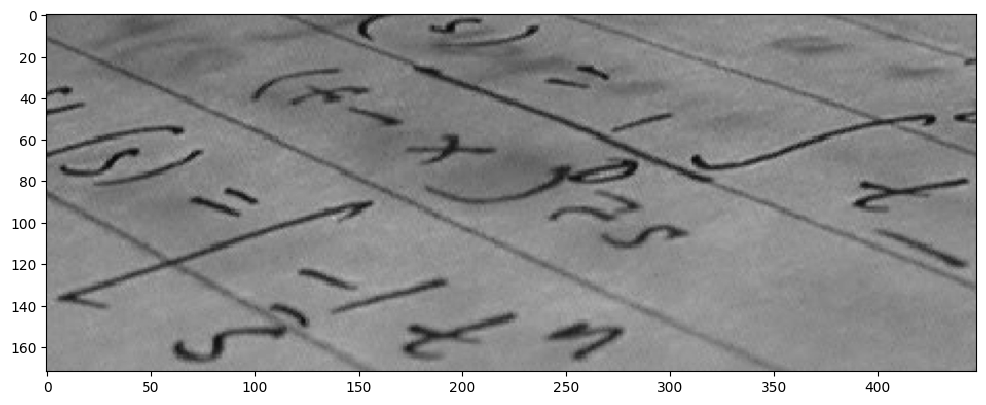

In [3]:
# We use a gray image. All the algorithms should work with color images too.
img = text() / 255.
plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.show()

Here are some sample affine transformations to be used later on

In [4]:
T_scale = np.array([
    [0.75, 0, 0],
    [0, 0.75, 0],
    [0, 0, 1],
])
T_shear = np.array([
    [1, 0.3, 0],
    [0, 1, 0],
    [0, 0, 1],
])

# you can use this function to invert the matrices
np.linalg.inv(T_scale)

array([[1.33333333, 0.        , 0.        ],
       [0.        , 1.33333333, 0.        ],
       [0.        , 0.        , 1.        ]])

In [5]:
def affine_transformation(img, matrix):
    corner = np.ceil([*img.shape[:2], 1] @ matrix)[:2].astype(int)
    indices = np.empty((*np.maximum(img.shape[:2], corner), 3))
    indices[:, :, 0] = np.arange(indices.shape[0])[:, None]  # y
    indices[:, :, 1] = np.arange(indices.shape[1])[None, :]  # x
    indices[:, :, 2] = 1
    # apply the inverse transformation to each [x, y, 1] utilizing matmul broadcasting
    indices = indices @ np.linalg.inv(matrix)
    image = np.copy(img)
    image = bilinear_interpolation(image, indices)
    return image

In [6]:
def bilinear_interpolation(img, indices):
    img = img.reshape((*img.shape[:2], -1))

    Y1 = indices[..., 0].astype(int)
    X1 = indices[..., 1].astype(int)

    # pad the image with zeros to avoid out of bounds
    pad0 = Y1.max() - img.shape[0] + 2
    pad1 = X1.max() - img.shape[1] + 2
    img = np.pad(img, ((1, pad0), (1, pad1), (0,0)),
                 mode='constant', constant_values=0)
    # account for padding
    Y1 = Y1 + 1
    X1 = X1 + 1

    q11 = img[Y1, X1]
    q21 = img[Y1, X1 + 1]
    q12 = img[Y1 + 1, X1]
    q22 = img[Y1 + 1, X1 + 1]
    q11[X1 < 0] = 0
    q12[X1 < 0] = 0
    q11[Y1 < 0] = 0
    q21[Y1 < 0] = 0
    q21[X1 + 1 < 0] = 0
    q22[X1 + 1 < 0] = 0
    q12[Y1 + 1 < 0] = 0
    q22[Y1 + 1 < 0] = 0

    # shift back since indices were not padded
    Y1 = Y1 - 1
    X1 = X1 - 1

    R1 = (X1 + 1 - indices[..., 1])[..., None] * q11 \
        + (indices[..., 1] - X1)[..., None] * q21
    R2 = (X1 + 1 - indices[..., 1])[..., None] * q12 \
        + (indices[..., 1] - X1)[..., None] * q22
    img = (Y1 + 1 - indices[..., 0])[..., None] * R1 \
        + (indices[..., 0] - Y1)[..., None] * R2

    image = np.copy(img)
    return image

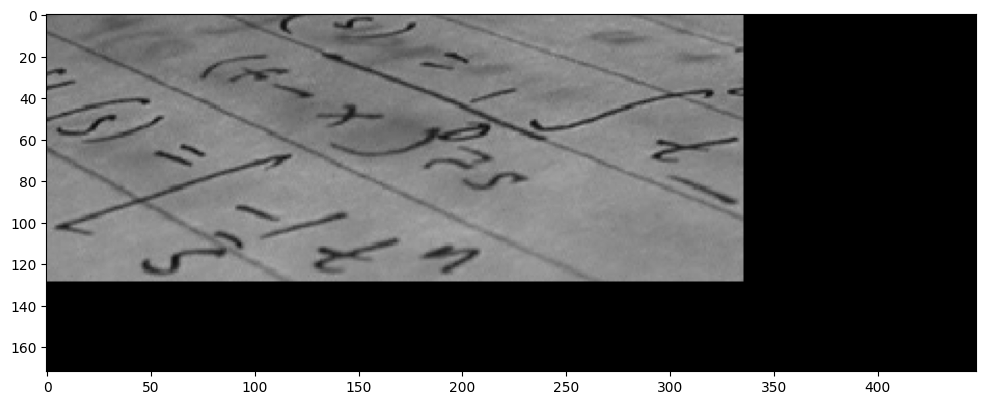

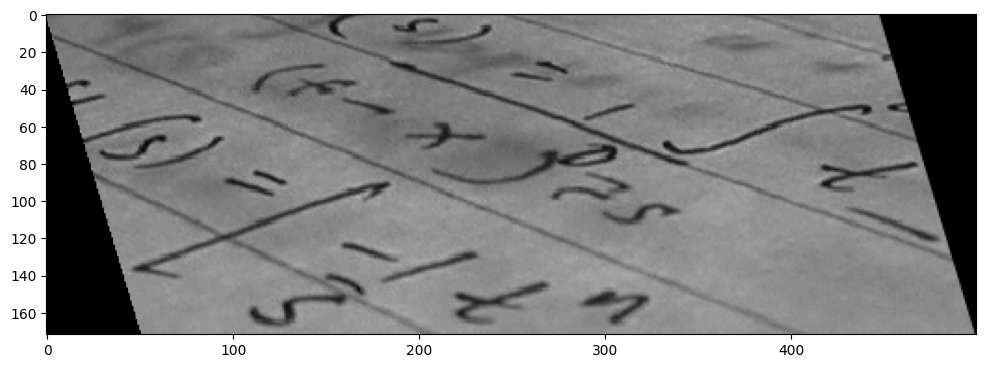

In [7]:
img_scale = affine_transformation(img, T_scale)
img_shear = affine_transformation(img, T_shear)
plt.imshow(img_scale, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(img_shear, cmap='gray', vmin=0, vmax=1)
plt.show()

# Exercise 2 - Bicubic interpolation - 6 Points

Implement affine transformation with [bicubic interpolation](https://en.wikipedia.org/wiki/Bicubic_interpolation).
Implement the functions `affine_transformation` and `bicubic_interpolation`. Apply some affine transformation of your choice and smooth the output using your bicubic interpolation.

In [8]:
def derive_y(image):
    """Computes the derivative of the image w.r.t the y coordinate"""
    _, dy = np.gradient(image, axis=(1, 0))
    return dy

def derive_x(image):
    """Computes the derivative of the image w.r.t the x coordinate"""
    dx, _ = np.gradient(image, axis=(1, 0))
    return dx

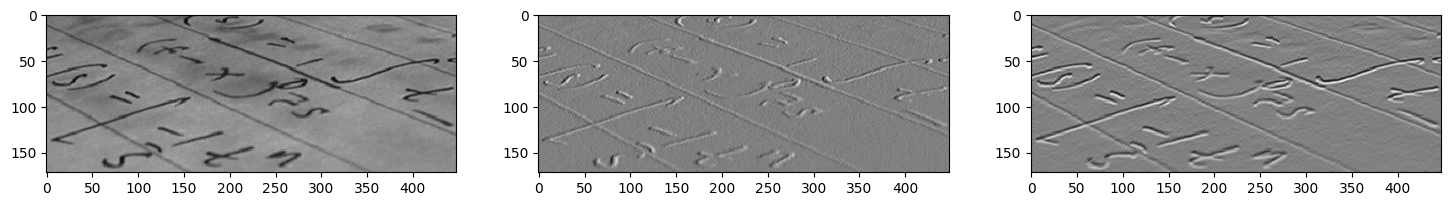

In [9]:
dx_img = derive_x(img)
dy_img = derive_y(img)
plt.figure(figsize=(18, 12))
plt.subplot(131)
plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.subplot(132)
plt.imshow(dx_img, cmap='gray')
plt.subplot(133)
plt.imshow(dy_img, cmap='gray')
plt.show()

Here are some sample affine transformations to be used later on

In [10]:
T_scale = np.array([
    [0.75, 0, 0],
    [0, 0.75, 0],
    [0, 0, 1],
])
T_affine = np.array([
    [1, 0.3, 0],
    [0, 1, 0],
    [0, 0, 1],
])

# you can use this function to invert the matrices
np.linalg.inv(T_scale)

array([[1.33333333, 0.        , 0.        ],
       [0.        , 1.33333333, 0.        ],
       [0.        , 0.        , 1.        ]])

In [11]:
np.linalg.inv(T_affine) @ [1, 1, 1]

array([0.7, 1. , 1. ])

In [12]:
A_inv = np.zeros((16, 16))
A_inv[0, 0] = 1
A_inv[1, 4] = 1
A_inv[2, :6] = [-3, 3, 0, 0, -2, -1]
A_inv[3, :6] = [2, -2, 0, 0, 1, 1]
A_inv[4, 8] = 1
A_inv[5, 12] = 1
A_inv[6, 8:14] = [-3, 3, 0, 0, -2, -1]
A_inv[7, 8:14] = [2, -2, 0, 0, 1, 1]
A_inv[8, 0:12:2] = [-3, 3, 0, 0, -2, -1]
A_inv[9, 4::2] = [-3, 3, 0, 0, -2, -1]
A_inv[10] = [9, -9, -9, 9, 6, 3, -6, -3, 6, -6, 3, -3, 4, 2, 2, 1]
A_inv[11] = [-6, 6, 6, -6, -3, -3, 3, 3, -4, 4, -2, 2, -2, -2, -1, -1]
A_inv[12, [0, 2, 8, 10]] = [2, -2, 1, 1]
A_inv[13, [4, 6, 12, 14]] = [2, -2, 1, 1]
A_inv[14] = [-6, 6, 6, -6, -4, -2, 4, 2, -3, 3, -3, 3, -2, -1, -2, -1]
A_inv[15] = [4, -4, -4, 4, 2, 2, -2, -2, 2, -2, 2, -2, 1, 1, 1, 1]
print(A_inv)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-3.  3.  0.  0. -2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2. -2.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -3.  3.  0.  0. -2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2. -2.  0.  0.  1.  1.  0.  0.]
 [-3.  0.  3.  0.  0.  0.  0.  0. -2.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -3.  0.  3.  0.  0.  0.  0.  0. -2.  0. -1.  0.]
 [ 9. -9. -9.  9.  6.  3. -6. -3.  6. -6.  3. -3.  4.  2.  2.  1.]
 [-6.  6.  6. -6. -3. -3.  3.  3. -4.  4. -2.  2. -2. -2. -1. -1.]
 [ 2.  0. -2.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0. -2.  0.  0.  0.  0.  0.  1.  0.  1.  0.]
 [-6.  6.  6. -6. -4. -2.  4.  2. -3.  3. -3.  3. -2. -1. -2. 

In [13]:
def affine_transformation(img, matrix):
    corner = np.ceil([*img.shape[:2], 1] @ matrix)[:2].astype(int)
    indices = np.empty((*np.maximum(img.shape[:2], corner), 3))
    indices[:, :, 0] = np.arange(indices.shape[0])[:, None]  # y
    indices[:, :, 1] = np.arange(indices.shape[1])[None, :]  # x
    indices[:, :, 2] = 1
    # apply the inverse transformation to each [x, y, 1] utilizing matmul broadcasting
    indices = indices @ np.linalg.inv(matrix)
    image = np.copy(img)
    image = bicubic_interpolation(image, indices)

    return image

In [14]:
def bicubic_interpolation(img, indices):
    img = img.reshape((*img.shape[:2], -1))

    Y0 = indices[..., 0].astype(int)
    X0 = indices[..., 1].astype(int)

    # pad the image with zeros to avoid out of bounds
    pad0 = Y0.max() - img.shape[0] + 1
    pad1 = X0.max() - img.shape[1] + 1
    img = np.pad(img, ((1, pad0 + 1), (1, pad1 + 1), (0, 0)),
                 mode='constant', constant_values=0)
    # account for the padding
    Y0 = Y0 + 1
    X0 = X0 + 1

    dx_img = derive_x(img)
    dy_img = derive_y(img)
    dxy_img = derive_x(dy_img)

    x = np.zeros((*indices.shape[:2], img.shape[2], 16))
    x[..., 0] = img[Y0, X0]
    x[..., 1] = img[Y0, X0 + 1]
    x[..., 2] = img[Y0 + 1, X0]
    x[..., 3] = img[Y0 + 1, X0 + 1]
    x[..., 4] = dx_img[Y0, X0]
    x[..., 5] = dx_img[Y0, X0 + 1]
    x[..., 6] = dx_img[Y0 + 1, X0]
    x[..., 7] = dx_img[Y0 + 1, X0 + 1]
    x[..., 8] = dy_img[Y0, X0]
    x[..., 9] = dy_img[Y0, X0 + 1]
    x[..., 10] = dy_img[Y0 + 1, X0]
    x[..., 11] = dy_img[Y0 + 1, X0 + 1]
    x[..., 12] = dxy_img[Y0, X0]
    x[..., 13] = dxy_img[Y0, X0 + 1]
    x[..., 14] = dxy_img[Y0 + 1, X0]
    x[..., 15] = dxy_img[Y0 + 1, X0 + 1]
    x[X0 < 0, 0::2] = 0
    x[Y0 < 0, 0::4] = 0
    x[Y0 < 0, 1::4] = 0
    x[X0 + 1 < 0, 1::2] = 0
    x[Y0 + 1 < 0, 2::4] = 0
    x[Y0 + 1 < 0, 3::4] = 0

    # shift back since indices were not padded
    Y0 = Y0 - 1
    X0 = X0 - 1

    a = x @ A_inv.T
    py = (indices[..., 0] - Y0)[..., None] ** np.arange(4)[None, None, :]
    px = (indices[..., 1] - X0)[..., None] ** np.arange(4)[None, None, :]
    img = np.sum(a * (px[..., None, :] * py[..., :, None]
                      ).reshape(*a.shape[:2], 1, -1), axis=-1)

    return img

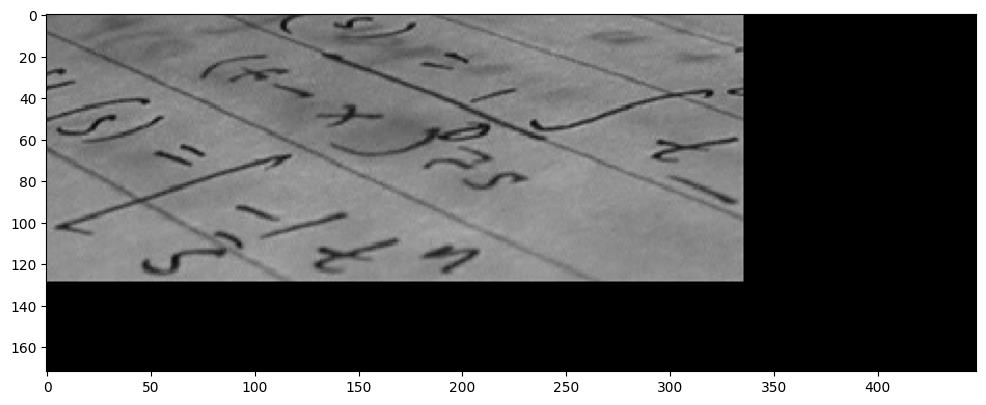

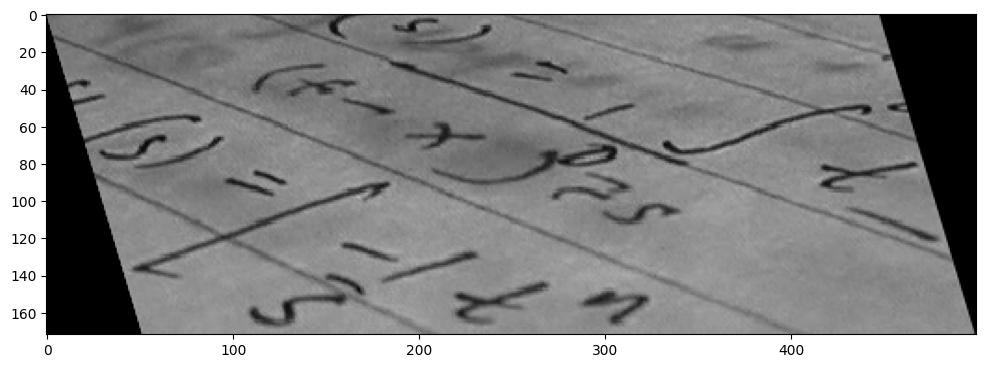

In [15]:
img_scale = affine_transformation(img, T_scale)
img_affine = affine_transformation(img, T_affine)
plt.imshow(img_scale, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(img_affine, cmap='gray', vmin=0, vmax=1)
plt.show()

# Exercise 3 - Implement a Histogram Mapping - 2 Points

In [16]:
def norm_cdf(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [17]:
def gamma_mapping(gamma):
    """
    Returns a 1-dimensional numpy array. The value of the array at the n-position 
    is `(n/len(array))**gamma`.
    """
    return norm_cdf(np.linspace(0, 1, 256)**gamma)


def sigmoid_mapping(gain = 10, cutoff = 0.5):
    """
    Returns a 1-dimensional numpy array. The value of the array at the n-position 
    is  `1/(1 + exp*(gain*(cutoff - (n/len(array)))))`.
    """
    return norm_cdf(1 / (1 + np.exp(gain * (cutoff - np.linspace(0, 1, 256)))))

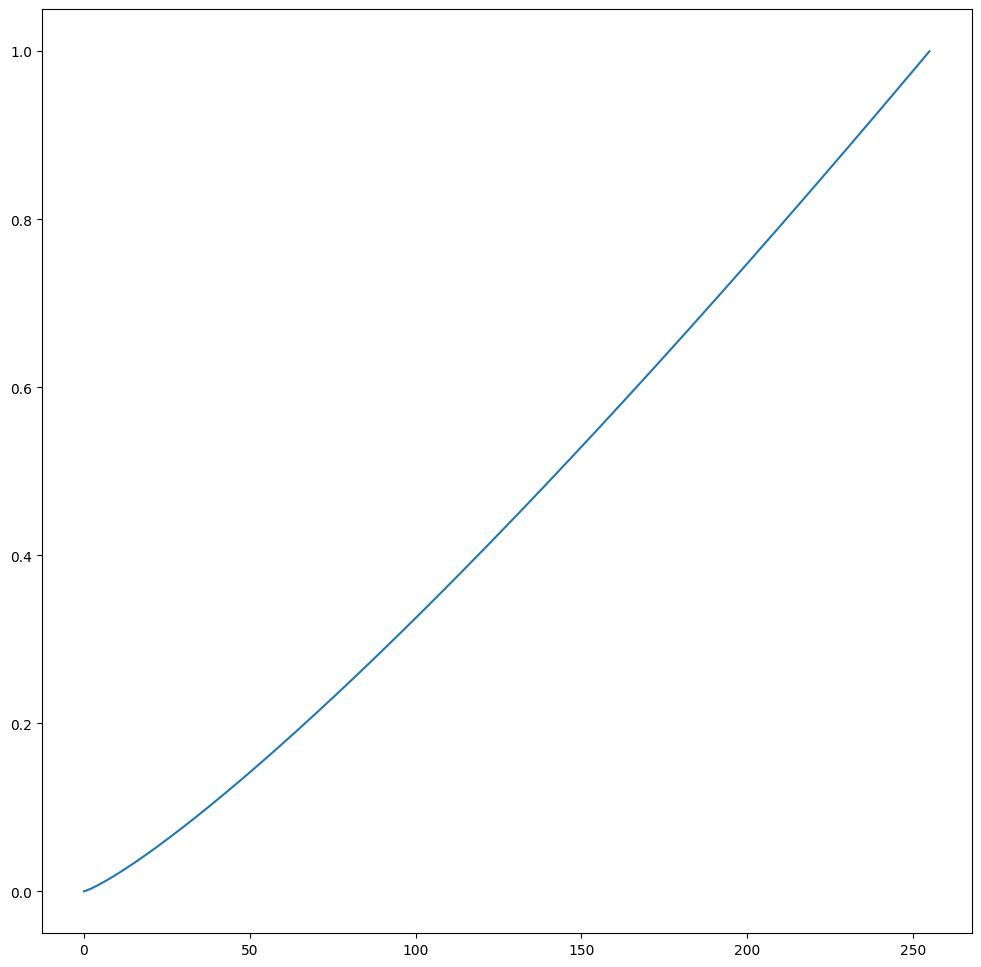

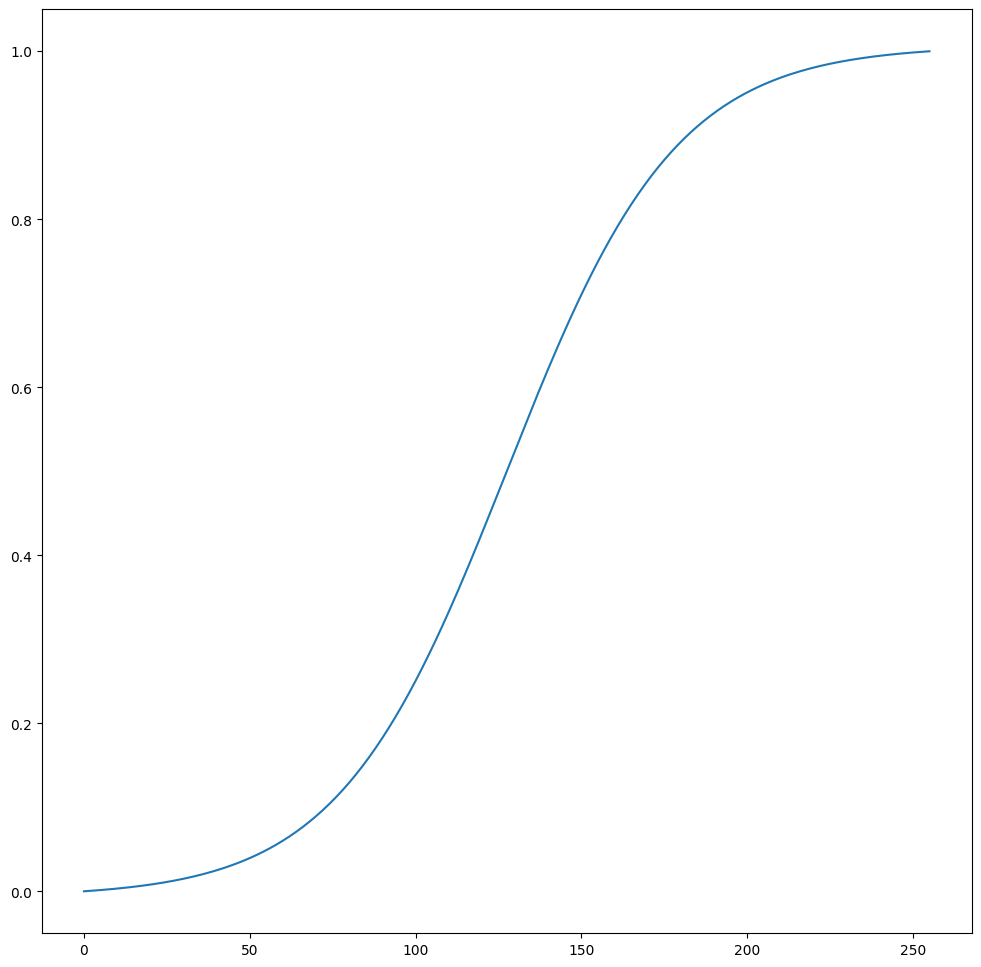

In [18]:
plt.plot(gamma_mapping(1.2))
plt.show()

plt.plot(sigmoid_mapping())
plt.show()

# Exercise 4 - Histogram Transformation - 2 Points

In [19]:
img = cat() / 255.
img_hsv = rgb2hsv(img)
img_gray = rgb2gray(img)

In [20]:
def apply_pixel_mapping(image, mapping):
    """Returns the image transformed according to the mapping array. 
       `mapping` is a one dimensional numpy array. `image` can be 2 or 3-dimensional.
       The values of the image are in range 0 to 1.
       If the mapping has for example 255 items, then all pixel with a value from 0 to 1/255 are assigned to 
       the value mapping[0]. If the pixel is between n / 255 and (n+1) / 255 then the value in the output image should 
       be mapping[n]
    """
    img = np.copy(image)
    img = (img * (mapping.size - 1)).astype(int)
    img = mapping[img]
    return img

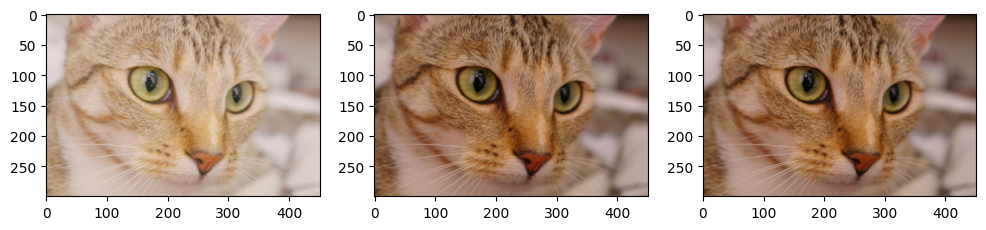

In [21]:
# you can test your `apply_pixel_mapping` function
# The first image should look lighter. The second and third should be the same image.
img_gamma05 = apply_pixel_mapping(img, gamma_mapping(0.5))
plt.subplot(131)
plt.imshow(img_gamma05)
plt.subplot(132)
plt.imshow(apply_pixel_mapping(img_gamma05, gamma_mapping(2)))
plt.subplot(133)
plt.imshow(img)
plt.show()

# Exercise 5 - Implement Histogram Equalisation - 2 Points

Equalize the image given image so that the histogram is mostly uniform distributed.
You can use `np.histogram` and `np.cumsum`. Checkout the documentation of `np.histogram`, it might have useful optional arguments.

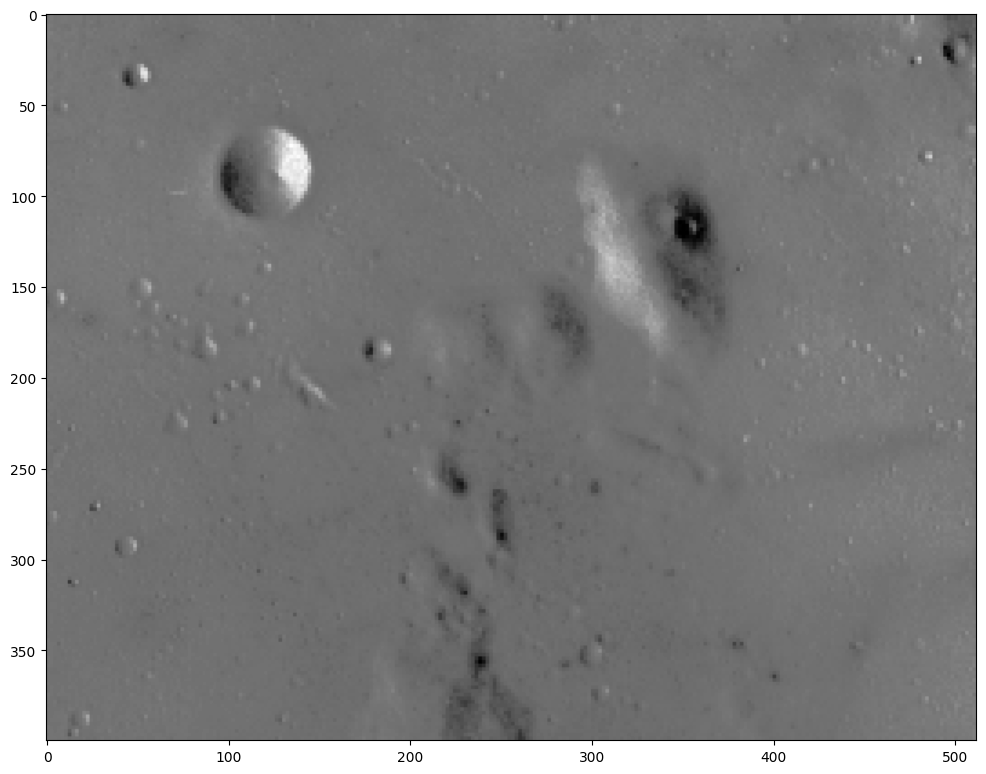

In [22]:
from skimage import data
moon = data.moon()[:400,:] / 255.
plt.imshow(moon, cmap='gray', vmin=0, vmax=1)
plt.show()

In [23]:
hist, bin_edges = np.histogram(moon, bins=256, range=(0, 256/255)) # get the histogram of the image
equalisation_mapping = hist.cumsum() / moon.size

In [24]:
img_equalised = apply_pixel_mapping(moon, equalisation_mapping)

In [25]:
# get the histogram of the equalised image
hist_of_equalised, bin_edges_of_equalised = np.histogram(img_equalised, bins=256, range=(0, 256/255))

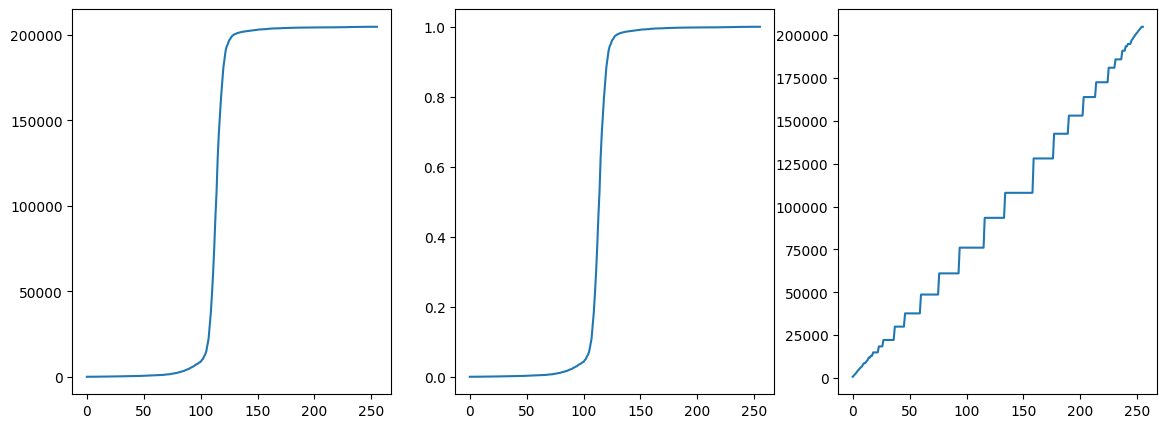

In [26]:
plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.plot(hist.cumsum())
plt.subplot(132)
plt.plot(equalisation_mapping)
plt.subplot(133)
plt.plot(hist_of_equalised.cumsum())
plt.show()

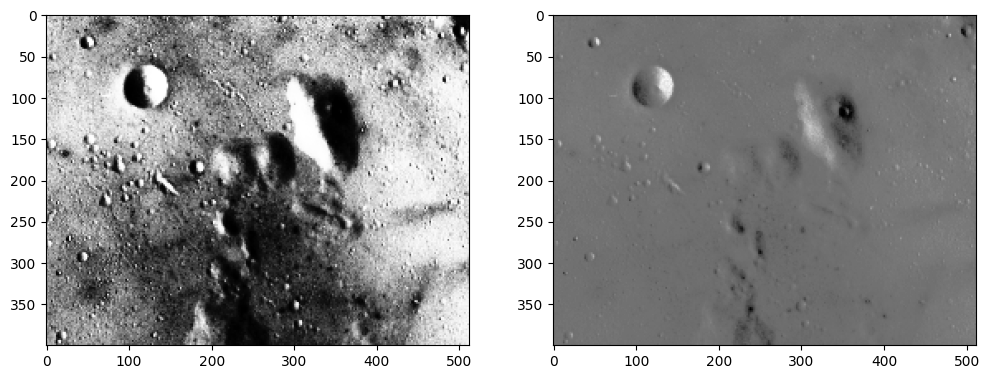

In [27]:
plt.subplot(121)
plt.imshow(img_equalised, cmap='gray', vmin=0, vmax=1)
plt.subplot(122)
plt.imshow(moon, cmap='gray', vmin=0, vmax=1)
plt.show()